In [9]:
import pandas as pd; 

#combined data sets
combined_data = { 
                  'train': pd.read_csv('../Football/train.csv'), 
                  'test': pd.read_csv('../Football/test.csv') 
                }

#data preprocessing. Giving numerical values to some features
replacements = [
    {'Is_Home_or_Away': 'Home'}, {'Is_Home_or_Away': 0},
    {'Is_Home_or_Away': 'Away'}, {'Is_Home_or_Away': 1},
    {'Is_Opponent_in_AP25_Preseason': 'Out'}, {'Is_Opponent_in_AP25_Preseason': 0},
    {'Is_Opponent_in_AP25_Preseason': 'In'}, {'Is_Opponent_in_AP25_Preseason': 1},
    {'Label': 'Lose'}, {'Label': 0},
    {'Label': 'Win'}, {'Label': 1}
]

for y in combined_data:
    for x in range(0,len(replacements) - 1)[::2]:
        combined_data[y] = combined_data[y].replace(replacements[x], replacements[x+1])

#To both sets, I applied a numerical value to the Media and the Opponent feature
def apply_conversion_to_values(column, new_column):
    codes = {}
    i = 0
    grouped_series = combined_data['train'][column].append(combined_data['test'][column])
    for g, _ in grouped_series.groupby(grouped_series):
        codes[g] = i
        i = i + 1
    for x in combined_data:
        combined_data[x][new_column] = combined_data[x][column].apply(lambda y: codes[y])
    return codes

media_codes = apply_conversion_to_values('Media', 'MediaCode')
opponent_codes = apply_conversion_to_values('Opponent', 'OpponentCode')

In [10]:
#Prepare data
import numpy as np;

xTrain = combined_data['train']
xTest = combined_data['test']
yTrain = xTrain.iloc[:,6]
yTest = xTest.iloc[:,6]

for x in ['ID', 'Date', 'Opponent', 'Media', 'Label']:
    xTrain = xTrain.drop(x,1)
    xTest = xTest.drop(x,1)

xTrain = np.array(xTrain)
xTest = np.array(xTest)
yTrain = np.array(yTrain)
yTest = np.array(yTest)

KNN from scratch results:
Accuracy: 0.83  with k = 7
Precision: 0.75
Recall: 0.67
F1 score: 0.7077464788732396


,ID,Label
0,25,Win
1,26,Win
2,27,Win
3,28,Win
4,29,Lose
5,30,Lose
6,31,Win
7,32,Lose
8,33,Win
9,34,Win


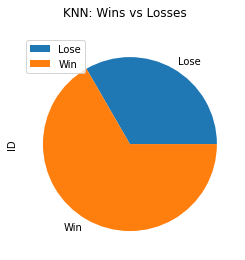

In [11]:
#KNN from Scratch
def euclidean_distances(xTrain,xTest,k):
    distances = -2 * xTrain@xTest.T + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    distances[distances < 0] = 0
    distances = distances**.5
    indices = np.argsort(distances, 0) 
    distances = np.sort(distances,0) 
    return indices[0:k,:], distances[0:k,:]

def knn(xTrain,yTrain,xTest,k=3):
    indices, distances = euclidean_distances(xTrain,xTest,k)
    yTrain = yTrain.flatten()
    rows, columns = indices.shape
    predictions = list()
    for j in range(columns):
        temp = list()
        for i in range(rows):
            cell = indices[i][j]
            temp.append(yTrain[cell])
        predictions.append(max(temp,key=temp.count))
    predictions=np.array(predictions)
    return predictions

def accuracy(yTest,predictions):
    x=yTest.flatten()==predictions.flatten()
    grade=np.mean(x)
    return np.round(grade,2)

def precision(yTest, predictions):
    tp = 0
    fp = 0
    for x in range(len(predictions)):
        if predictions[x] == 1:
            if yTest[x] == 1:
                tp = tp+1
            else:
                fp = fp+1
    return np.round(tp/(tp+fp), 2)
def recall(yTest, predictions):
    tp = 0
    fn = 0
    for x in range(len(predictions)):
        if predictions[x] == 1:
            if yTest[x] == 1:
                tp = tp+1
        else:
            if yTest[x] == 1:
                fn = fn+1
    return np.round(tp/(tp+fn), 2)
def f1_score(total_recall, total_precision):
    return 2*(total_recall*total_precision)/(total_recall+total_precision)

def results_table(predictions):
    return pd.DataFrame({'ID': list(range(25, 37)), 'Label': map(lambda x: 'Win' if x == 1 else 'Lose', predictions)})

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
predictions = []
for n in range(1,Ks):
    p = knn(xTrain,yTrain,xTest,n)
    mean_acc[n-1] = accuracy(yTest, p)
    std_acc[n-1] = np.std(p==yTest)/np.sqrt(p.shape[0])
    predictions.append(p)

total_precision = precision(yTest, predictions[-1])
total_recall = recall(yTest, predictions[-1])

print('KNN from scratch results:')
print('Accuracy:', np.round(mean_acc.max(),2), ' with k =', mean_acc.argmax()+1)
print('Precision:', total_precision)
print('Recall:', total_recall)
print('F1 score:', f1_score(total_recall, total_precision))

table = results_table(predictions[-1])

table.groupby('Label').count().plot(kind='pie', title='KNN: Wins vs Losses', subplots=True);

table


Naïve Bayes results:
Accuracy: 0.83
Precision: 1.0
Recall: 0.78
F1 score: 0.8764044943820225


,ID,Label
0,25,Win
1,26,Lose
2,27,Win
3,28,Win
4,29,Win
5,30,Lose
6,31,Lose
7,32,Win
8,33,Win
9,34,Lose


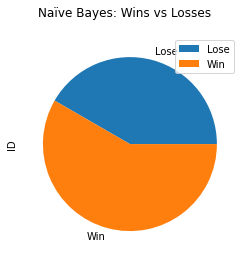

In [12]:
#Naïve Bayes sklearn
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(xTrain, yTrain)
predictions = gnb.predict(xTest)

total_precision = precision(yTest, predictions)
total_recall = recall(yTest, predictions)

print('Naïve Bayes results:')
print('Accuracy:', accuracy(yTest, predictions))
print('Precision:', total_precision)
print('Recall:', total_recall)
print('F1 score:', f1_score(total_recall, total_precision))

table = results_table(predictions)

table.groupby('Label').count().plot(kind='pie', title='Naïve Bayes: Wins vs Losses', subplots=True);

table